In [121]:
import pickle

with open('train.pickle', 'rb') as handle:
     train = pickle.load(handle)
with open('test.pickle', 'rb') as handle:
     test = pickle.load(handle)


In [122]:
#code for the first task, extend the same to the other tasks as well
#adjacent weight sharing

HOPS=3
V = -1 #find the vocabulary size
maxlen = -1 #find the maximum length of a sentence
vocab = {} #find the distinct number of words

In [123]:
#Preprocess the training data
import re
punctuation = re.compile(r'[-.?!,":;()|0-9]')
for idx in range(20):
    for key,data in zip(train[idx+1].keys(),train[idx+1].values()):
        memories = data['memory']

        query = data['query'].strip('\n')
        data['query'] = punctuation.sub("", query).strip().lower().split()
        maxlen = max(maxlen,len(data['query']))
        for word in data['query']:
            if word not in vocab:
                vocab[word] = len(vocab)+1

        answer = data['answer'].strip('\n')
        data['answer'] = punctuation.sub("", answer).strip().lower().split()
        maxlen = max(maxlen,len(data['answer']))
        for word in data['answer']:

            if word not in vocab:
                vocab[word] = len(vocab)+1

        data['fact'] = data['fact'].strip('\n').strip()

        for i in range(len(memories)):
            memories[i] = memories[i].strip('\n')
            memories[i] = punctuation.sub("", memories[i])
            memories[i] = memories[i].strip().lower().split()
            maxlen = max(maxlen,len(memories[i]))

            for word in memories[i]:
                if word not in vocab:
                    vocab[word] = len(vocab)+1

        data['memory'] = memories
        train[idx+1][key] = data
    
    

In [124]:
#Preprocess the testing data
import re
punctuation = re.compile(r'[-.?!,":;()|0-9]')
for idx in range(20):
    for key,data in zip(test[idx+1].keys(),test[idx+1].values()):
        memories = data['memory']

        query = data['query'].strip('\n')
        data['query'] = punctuation.sub("", query).strip().lower().split()
        maxlen = max(maxlen,len(data['query']))
        for word in data['query']:
            if word not in vocab:
                vocab[word] = len(vocab)+1

        answer = data['answer'].strip('\n')
        data['answer'] = punctuation.sub("", answer).strip().lower().split()
        maxlen = max(maxlen,len(data['answer']))
        for word in data['answer']:

            if word not in vocab:
                vocab[word] = len(vocab)+1

        data['fact'] = data['fact'].strip('\n').strip()

        for i in range(len(memories)):
            memories[i] = memories[i].strip('\n')
            memories[i] = punctuation.sub("", memories[i])
            memories[i] = memories[i].strip().lower().split()
            maxlen = max(maxlen,len(memories[i]))

            for word in memories[i]:
                if word not in vocab:
                    vocab[word] = len(vocab)+1

        data['memory'] = memories
        test[idx+1][key] = data
    
    

In [126]:
vocab['<PAD>'] = 0
V = len(vocab)
d = 50
H=3
RN=True
MEM_SIZE = 50
BATCH_SIZE = 32

In [127]:
import torch
import torch . nn as nn
import torch . nn . functional as F
import torch.autograd as ag
import numpy as np
# This is our neural networks class
class MemN2N ( nn . Module ):
# Here we define our netwrok structure
    
    def getGaussianMatrix(self,Vo,dim):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, Vo*dim)
        s = s.reshape(Vo,-1)
        s[0] = 0
        return s
    
    def getGaussianMatrix3D(self,x,y,z):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, x*y*z)
        s = s.reshape(x,y,z)
        return s

    def constrainPadding(self):
        self.C0.weight.data[0] = 0
        self.C1.weight.data[0] = 0
        self.C2.weight.data[0] = 0
        self.C3.weight.data[0] = 0

        
    def __init__ ( self, vocab_size = V, embedding_dim = (V,d), hops = H):
        super ( MemN2N,self ). __init__ ()
        self.MEM_SIZE = MEM_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.RN = RN
        self.d = d
        self.maxlen = maxlen
#         self.memory_size = ag.Variable(torch.zeros(BATCH_SIZE).int().cuda(),requires_grad=False)
        self.L = np.zeros((maxlen,d))
        self.linear_mode = True
        for k in range(self.L.shape[1]-1):
            for j in range(self.L.shape[0]-1):
                self.L[j,k] = (1-float(j+1)/self.L.shape[0]) - ((k+1)/self.L.shape[1])*(1-(2*float(j+1))/self.L.shape[0])
        if torch.cuda.is_available():
            self.L = ag.Variable(torch.from_numpy(self.L).contiguous().cuda(),requires_grad=False)
        else:
            self.L = ag.Variable(torch.from_numpy(self.L).contiguous(),requires_grad=False)

#         self.memories = ag.Variable(torch.zeros(BATCH_SIZE,MEM_SIZE,d).double().cuda(),requires_grad=False)
#         self.output_memories = ag.Variable(torch.zeros(BATCH_SIZE,MEM_SIZE,d).double().cuda(),requires_grad=False)
        self.V = vocab_size
        self.embedding_dim = embedding_dim
        self.hops = hops
        self.C0 = nn . Embedding (embedding_dim[0] , embedding_dim[1], padding_idx=0).double()
        self.C1 = nn . Embedding (embedding_dim[0] , embedding_dim[1], padding_idx=0).double()
        self.C2 = nn . Embedding (embedding_dim[0] , embedding_dim[1], padding_idx=0).double()
        self.C3 = nn . Embedding (embedding_dim[0] , embedding_dim[1], padding_idx=0).double()
        
        #initialize random weight based on Gaussian Distribution
        
        self.C0.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.V,self.d)))
        self.C1.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.V,self.d)))
        self.C2.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.V,self.d)))
        self.C3.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.V,self.d)))

        self.T_C0 = nn . Embedding (self.MEM_SIZE, embedding_dim[1], padding_idx=0).double()
        self.T_C1 = nn . Embedding (self.MEM_SIZE, embedding_dim[1], padding_idx=0).double()
        self.T_C2 = nn . Embedding (self.MEM_SIZE , embedding_dim[1], padding_idx=0).double()
        self.T_C3 = nn . Embedding (self.MEM_SIZE , embedding_dim[1], padding_idx=0).double()
        
        #initialize random weight based on Gaussian Distribution
        
        self.T_C0.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.MEM_SIZE,self.d)))
        self.T_C1.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.MEM_SIZE,self.d)))
        self.T_C2.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.MEM_SIZE,self.d)))
        self.T_C3.weight.data.copy_(torch.from_numpy(self.getGaussianMatrix(self.MEM_SIZE,self.d)))

        
        #initialize zero weight to padded input
        
        #initialize zero weight to padded input
#         self.constrainPadding()
        
        if torch.cuda.is_available():
            self.C0 = self.C0.cuda()
            self.C1 = self.C1.cuda()
            self.C2 = self.C2.cuda()
            self.C3 = self.C3.cuda()
            self.T_C0 = self.T_C0.cuda()
            self.T_C1 = self.T_C1.cuda()
            self.T_C2 = self.T_C2.cuda()
            self.T_C3 = self.T_C3.cuda()
    
    def reset_memory(self):
        self.memories = None
        self.output_memories = None
        
        
    def forward ( self , x , q ,temp):
            
        A_k = self.C0
        B_k = self.C0
        C_k = self.C1
        
        A_k_T = self.T_C0
        C_k_T = self.T_C1
            
        
        mat = self.L.unsqueeze(0).repeat(self.BATCH_SIZE,1,1)
#         mat = self.L.repeat(self.BATCH_SIZE)
        Q = B_k(q)*mat

#         print(weighted_Q.view(-1,d,d))
        Q = torch.sum(Q,dim=1)
        mat1 = self.L.unsqueeze(0).repeat(self.BATCH_SIZE*self.MEM_SIZE,1,1)
        x = x.view(-1,self.maxlen)
        
        for i in range(self.hops):
            self.reset_memory()
            C_k = getattr(self, 'C'+str(i+1))
            C_k_T = getattr(self, 'T_C'+str(i+1))
            
#             print(x.size())
            
#             mat = self.L.repeat(self.BATCH_SIZE,self.MEM_SIZE)
            weighted_M = (A_k(x)*mat1).view(self.BATCH_SIZE,self.MEM_SIZE,self.maxlen,-1)
            weighted_O = (C_k(x)*mat1).view(self.BATCH_SIZE,self.MEM_SIZE,self.maxlen,-1)
            sum_M = torch.sum(weighted_M,dim=2)
            sum_O = torch.sum(weighted_O,dim=2)
            
            if torch.cuda.is_available():
                temporal_encoding = ag.Variable(torch.from_numpy(temp).long().cuda())
            else:
                temporal_encoding = ag.Variable(torch.from_numpy(temp).long())

            self.memories = sum_M + A_k_T(temporal_encoding)
            self.output_memories = sum_O + C_k_T(temporal_encoding)
            
            
#             if(RN == True):
#                 s1 = self.getGaussianMatrix3D(self.BATCH_SIZE,(int(self.MEM_SIZE/10)),self.d)
#                 s2 = self.getGaussianMatrix3D(self.BATCH_SIZE,(int(self.MEM_SIZE/10)),self.d)
#                 if torch.cuda.is_available():
#                     noise1 = ag.Variable(torch.from_numpy(s1).double().cuda())    
#                     noise2 = ag.Variable(torch.from_numpy(s2).double().cuda())    
#                 else:
#                     noise1 = ag.Variable(torch.from_numpy(s1).double())    
#                     noise2 = ag.Variable(torch.from_numpy(s2).double())    
                
#                 self.memories = torch.cat((self.memories,noise1),dim=1)
#                 self.output_memories = torch.cat((self.output_memories,noise2),dim=1)
                
#                 self.MEM_SIZE = int(1.1*self.MEM_SIZE)
            
            product = torch.bmm(Q.unsqueeze(1).repeat(1,self.MEM_SIZE,1).unsqueeze(3).permute(0,1,3,2).view(-1,1,d),self.memories.unsqueeze(3).view(-1,self.d,1)) # batch size x 50
#           print(product.size())
            product = product.view(self.BATCH_SIZE,self.MEM_SIZE,1).squeeze(2)
            if(self.linear_mode == False):
                product = F.softmax(product, dim=1) # batch size x 50
#             print(product[1])
            product = product.unsqueeze(2).repeat(1,1,self.d)
            O_k = torch.sum(product*self.output_memories, dim = 1)
#             print(O_k.shape)
#             print(Q.shape)
            Q = Q + O_k #batch size x d
            A_k = C_k
            A_k_T = C_k_T
            
#         self.constrainPadding()
        output = torch.mm(Q,C_k.weight.permute(1,0))
        values, indices = torch.max(output,1)
#         print(indices)
        return output
                
    # This is a helper function to understand the dimensions
    def num_flat_features ( self , x ):
        size = x.size()[1:] # all dimensions except the batch dimension
        return np.prod(size)

def network():
    net = MemN2N ()
    net.hops = 3
    print ( net )
    # for name,param in list(net.named_parameters()):
    #     if param.requires_grad:
    #         print name, param.data
    if torch.cuda.is_available():
        net = net.cuda()
    return net




In [31]:
net = network()

MemN2N(
  (C0): Embedding(175, 50, padding_idx=0)
  (C1): Embedding(175, 50, padding_idx=0)
  (C2): Embedding(175, 50, padding_idx=0)
  (C3): Embedding(175, 50, padding_idx=0)
  (T_C0): Embedding(50, 50, padding_idx=0)
  (T_C1): Embedding(50, 50, padding_idx=0)
  (T_C2): Embedding(50, 50, padding_idx=0)
  (T_C3): Embedding(50, 50, padding_idx=0)
)


In [32]:
NUM_SAMPLES = 1000
NUM_BATCHES = (NUM_SAMPLES+BATCH_SIZE-1)/BATCH_SIZE
gamma = 0.01
gamma_i = 0.005
NUM_EPOCHS = 200
optimizer = torch . optim . SGD ( net . parameters () , lr = gamma_i)
scheduler = torch . optim . lr_scheduler . StepLR(optimizer, step_size=NUM_EPOCHS/4, gamma=1)
clip = 40


In [128]:
def strictly_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def trainer():
    if torch.cuda.is_available():
        criterion = nn . CrossEntropyLoss ().cuda()
    else:
        criterion = nn . CrossEntropyLoss ()

    NUM_SAMPLES = 1000
    NUM_BATCHES = (NUM_SAMPLES+BATCH_SIZE-1)/BATCH_SIZE
    gamma = 0.1
    gamma_i = 0.005
    NUM_EPOCHS = 300
    optimizer = torch . optim . SGD ( net . parameters () , lr = gamma_i)
    scheduler = torch . optim . lr_scheduler . StepLR(optimizer, step_size=NUM_EPOCHS/4, gamma=1)
    clip = 40

    task_perm = np.random.permutation(20)
    # task_perm = [1]
    net.linear_mode = True
    flag = True
    loss_arr = []
    val_arr = []
    length = dict()
    nptasks = dict()
    training_data = dict()
    validation_data = dict()
    train_perm = dict()
    valid_perm = dict()
    batch_perm = dict()
    memories = dict()
    memories_valid = dict()

    batch_perm_valid = dict()
    # for task in task_perm:
    #     nptasks[task] = train[task+1].values()
    #     length[task] = len(nptasks[task]) 
    #     perm = np.arange(min(NUM_SAMPLES,length[task]))
    #     train_perm[task] = perm[:int(0.9*min(NUM_SAMPLES,length[task]))]
    #     valid_perm[task] = perm[int(0.9*min(NUM_SAMPLES,length[task])):]
    #     training_data[task] = train[task+1].values()[:int(0.9*min(NUM_SAMPLES,length[task]))]
    #     validation_data[task] = nptasks[task][int(0.9*min(NUM_SAMPLES,length[task])):]


    for epoch in range(NUM_EPOCHS):  

        task_perm = np.random.permutation(20)

        for task in task_perm:
    #         batch_perm[task] = np.arange(len(training_data[task]))
    #         batch_perm_valid[task] = np.arange(len(validation_data[task]))
            memories[task] = []
            memories_valid[task] = []


        running_loss = 0
        running_valid = 0
        scheduler.step()

        for i in range(int(NUM_BATCHES*0.9)):

            for task_i in task_perm:


    #             batch_perm_t = batch_perm[task_i][BATCH_SIZE*i:BATCH_SIZE*(i+1)]
                training_batch = train[task_i+1].values()[:int(0.9*min(NUM_SAMPLES,len(train[task_i+1].values())))][BATCH_SIZE*i:BATCH_SIZE*(i+1)]


                inputs = np.zeros((BATCH_SIZE,MEM_SIZE,maxlen))

                queries = np.zeros((BATCH_SIZE,maxlen))

                outputs = np.zeros((BATCH_SIZE))


                temporal_encoding = np.zeros((BATCH_SIZE,MEM_SIZE))
                for batch,batch_i in zip(training_batch,range(BATCH_SIZE)):
                    for memory,mem_i in zip(batch['memory'],range(len(batch['memory']))):
                        memories[task_i].append(memory)
                        if(len(memories[task_i])>MEM_SIZE):
                            memories[task_i].pop(0)

                    for memory,mem_i in zip(reversed(memories[task_i]),range(min(len(memories[task_i]),45))):
                        for memory_word,word_i in zip(memory,range(len(memory))):
                            inputs[batch_i,mem_i,word_i] = vocab[memory_word]
                        temporal_encoding[batch_i,mem_i] = mem_i+1

                    for query_word,query_word_i in zip(batch['query'],range(len(batch['query']))):
                            queries[batch_i,query_word_i] = vocab[query_word]
                    outputs[batch_i] = vocab[batch['answer'][0]]


                if torch.cuda.is_available():
                    inputs = ag.Variable(torch.from_numpy(inputs).long().cuda())
                    queries = ag.Variable(torch.from_numpy(queries).long().cuda())
                    outputs = ag.Variable(torch.from_numpy(outputs).long().cuda())
                else:
                    inputs = ag.Variable(torch.from_numpy(inputs).long())
                    queries = ag.Variable(torch.from_numpy(queries).long())
                    outputs = ag.Variable(torch.from_numpy(outputs).long())



                net.zero_grad()
                op = net(inputs,queries,temporal_encoding)
#                 print(outputs)
#                 print(batch)
#                 print(inputs)
                loss = criterion(op,outputs).cuda()
                loss.backward()
                for name,param in list(net.named_parameters()):
                    if param.requires_grad :
                        param.grad[0] = 0


    #             for p in net.parameters():
    #                 param_norm = p.grad.data.norm(2)
    #                 if(param_norm > clip):
    #                     p.grad.data.mul_(clip/param_norm)

                nn.utils.clip_grad_norm(net.parameters(), clip, 2)
    #             for p in net.parameters():
    #                 param_norm = p.grad.data.norm(2)
    #                 if(param_norm > clip):
    #                     p.grad.data.mul_(clip/param_norm)


                optimizer.step()
                running_loss += loss[0]
    #         if i % 20 == 19:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/(20*len(task_perm))))
        loss_arr.append(running_loss)
        
        for i in range(int(0.9*NUM_BATCHES),NUM_BATCHES):

            for task_i in task_perm:

                valid_start = BATCH_SIZE*i
                valid_end = BATCH_SIZE*(i+1)

    #             batch_perm_valid_t = batch_perm_valid[task_i][valid_start:valid_end]
    #             print(batch_perm_valid_t)

                validation_batch = train[task_i+1].values()[valid_start:valid_end]



                inputs = np.zeros((BATCH_SIZE,MEM_SIZE,maxlen))

                queries = np.zeros((BATCH_SIZE,maxlen))

                outputs = np.zeros((BATCH_SIZE))


                temporal_encoding = np.zeros((BATCH_SIZE,MEM_SIZE))
                for batch,batch_i in zip(validation_batch,range(BATCH_SIZE)):
                    for memory,mem_i in zip(batch['memory'],range(len(batch['memory']))):
                        memories_valid[task_i].append(memory)
                        if(len(memories_valid[task_i])>MEM_SIZE):
                            memories_valid[task_i].pop(0)

                    for memory,mem_i in zip(reversed(memories_valid[task_i]),range(min(len(memories_valid[task_i]),45))):
                        for memory_word,word_i in zip(memory,range(len(memory))):
                            inputs[batch_i,mem_i,word_i] = vocab[memory_word]
                        temporal_encoding[batch_i,mem_i] = mem_i+1

                    for query_word,query_word_i in zip(batch['query'],range(len(batch['query']))):
                            queries[batch_i,query_word_i] = vocab[query_word]
                    outputs[batch_i] = vocab[batch['answer'][0]]

                if torch.cuda.is_available():
                    inputs = ag.Variable(torch.from_numpy(inputs).long().cuda())
                    queries = ag.Variable(torch.from_numpy(queries).long().cuda())
                    outputs = ag.Variable(torch.from_numpy(outputs).long().cuda())
                else:
                    inputs = ag.Variable(torch.from_numpy(inputs).long())
                    queries = ag.Variable(torch.from_numpy(queries).long())
                    outputs = ag.Variable(torch.from_numpy(outputs).long())


                op1 = net(inputs,queries,temporal_encoding)
                loss1 = criterion(op1,outputs).cuda()

                running_valid += loss1[0]

    #         if i % 20 == 19:
        print('[%d, %5d] valid loss: %.3f' % (epoch + 1, i + 1, running_valid))
        val_arr.append(round(float(running_valid[0].data),5))

        if(flag == True):
            if len(val_arr)>=2 and strictly_decreasing(val_arr[-2:]):
                net.linear_mode = False
                for param_group in optimizer.param_groups:
                    param_group['lr'] = gamma
                    scheduler.gamma = 0.5
                    print 'Linear Start Complete'
                    flag = False
    
    return val_arr,loss_arr




In [129]:
def accuracy_func(task):
    accuracy = []
    testing_data = np.array(test[task+1].values())
    length = len(testing_data) 
    memories = []
    for i in range(min(NUM_BATCHES,(length+BATCH_SIZE-1)/BATCH_SIZE)):
        testing_batch = testing_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    #             print(testing_batch)

        inputs = np.zeros((BATCH_SIZE,MEM_SIZE,maxlen))

        queries = np.zeros((BATCH_SIZE,maxlen))

        outputs = np.zeros((BATCH_SIZE))


        temporal_encoding = np.zeros((BATCH_SIZE,MEM_SIZE))
        for batch,batch_i in zip(testing_batch,range(BATCH_SIZE)):
            for memory,mem_i in zip(batch['memory'],range(len(batch['memory']))):
                memories.append(memory)
                if(len(memories)>MEM_SIZE):
                    memories.pop(0)

            for memory,mem_i in zip(reversed(memories),range(min(len(memories),45))):
                for memory_word,word_i in zip(memory,range(len(memory))):
                    inputs[batch_i,mem_i,word_i] = vocab[memory_word]
                temporal_encoding[batch_i,mem_i] = mem_i+1

            for query_word,query_word_i in zip(batch['query'],range(len(batch['query']))):
                    queries[batch_i,query_word_i] = vocab[query_word]
            outputs[batch_i] = vocab[batch['answer'][0]]

        if torch.cuda.is_available():
            inputs = ag.Variable(torch.from_numpy(inputs).long().cuda())
            queries = ag.Variable(torch.from_numpy(queries).long().cuda())
            outputs = ag.Variable(torch.from_numpy(outputs).long().cuda())
        else:
            inputs = ag.Variable(torch.from_numpy(inputs).long())
            queries = ag.Variable(torch.from_numpy(queries).long())
            outputs = ag.Variable(torch.from_numpy(outputs).long())



        op_test = net(inputs,queries,temporal_encoding)
        acc = np.mean(np.argmax(op_test.data.cpu().numpy(),axis=1) == outputs.data.cpu().numpy())

        accuracy.append(acc)
    return np.mean(accuracy)



In [52]:
val_loss = []
train_loss = []
accuracy_test = []
for rand in range(1):
    net = network()
    val_arr,loss_arr = trainer()
    
    val_loss.append(val_arr)
    train_loss.append(loss_arr)
    
    accuracy_temp = []
    for task in range(20):
        accuracy_temp.append(accuracy_func(task))
    
    accuracy_test.append(accuracy_temp)

MemN2N(
  (C0): Embedding(175, 50, padding_idx=0)
  (C1): Embedding(175, 50, padding_idx=0)
  (C2): Embedding(175, 50, padding_idx=0)
  (C3): Embedding(175, 50, padding_idx=0)
  (T_C0): Embedding(50, 50, padding_idx=0)
  (T_C1): Embedding(50, 50, padding_idx=0)
  (T_C2): Embedding(50, 50, padding_idx=0)
  (T_C3): Embedding(50, 50, padding_idx=0)
)
[1,    28] loss: 457.015
[1,    32] valid loss: 289.188
[2,    28] loss: 4.865
[2,    32] valid loss: 245.544
[3,    28] loss: 3.643
[3,    32] valid loss: 236.084
[4,    28] loss: 3.384
[4,    32] valid loss: 236.603
Linear Start Complete
[5,    28] loss: 6.561
[5,    32] valid loss: 348.083
[6,    28] loss: 5.070
[6,    32] valid loss: 298.586
[7,    28] loss: 4.492
[7,    32] valid loss: 283.310
[8,    28] loss: 4.211
[8,    32] valid loss: 272.223
[9,    28] loss: 3.992
[9,    32] valid loss: 263.142
[10,    28] loss: 3.809
[10,    32] valid loss: 255.342
[11,    28] loss: 3.652
[11,    32] valid loss: 248.749
[12,    28] loss: 3.520
[12,

[140,    28] loss: 1.973
[140,    32] valid loss: 179.952
[141,    28] loss: 1.965
[141,    32] valid loss: 179.560
[142,    28] loss: 1.959
[142,    32] valid loss: 179.219
[143,    28] loss: 1.952
[143,    32] valid loss: 178.921
[144,    28] loss: 1.945
[144,    32] valid loss: 178.747
[145,    28] loss: 1.939
[145,    32] valid loss: 178.484
[146,    28] loss: 1.934
[146,    32] valid loss: 178.280
[147,    28] loss: 1.926
[147,    32] valid loss: 177.990
[148,    28] loss: 1.922
[148,    32] valid loss: 177.748
[149,    28] loss: 1.915
[149,    32] valid loss: 177.521
[150,    28] loss: 1.909
[150,    32] valid loss: 177.283
[151,    28] loss: 1.904
[151,    32] valid loss: 177.098
[152,    28] loss: 1.899
[152,    32] valid loss: 176.848
[153,    28] loss: 1.892
[153,    32] valid loss: 176.634
[154,    28] loss: 1.887
[154,    32] valid loss: 176.491
[155,    28] loss: 1.882
[155,    32] valid loss: 176.266
[156,    28] loss: 1.878
[156,    32] valid loss: 176.114
[157,    28] l

[281,    32] valid loss: 164.921
[282,    28] loss: 1.550
[282,    32] valid loss: 164.932
[283,    28] loss: 1.548
[283,    32] valid loss: 164.921
[284,    28] loss: 1.546
[284,    32] valid loss: 164.897
[285,    28] loss: 1.545
[285,    32] valid loss: 164.797
[286,    28] loss: 1.544
[286,    32] valid loss: 164.796
[287,    28] loss: 1.542
[287,    32] valid loss: 164.956


KeyboardInterrupt: 

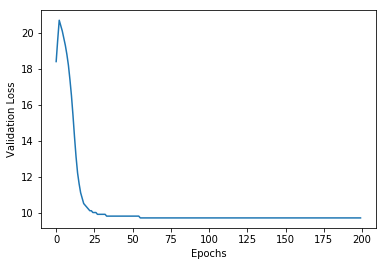

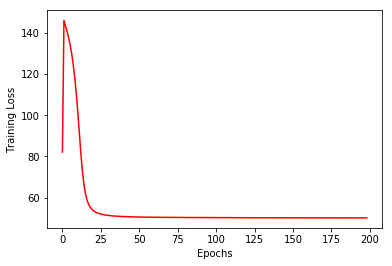

In [108]:
import matplotlib.pyplot as plt

def plot():
    
    plt.plot(np.arange(len(val_loss[0])),np.array(val_loss[0]),'-')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.show()
    tr = []
    for t in train_loss[0]:
        tr.append(float(t[0].data))
    plt.plot(np.arange(len(tr[1:])),np.array(tr[1:]),'r-')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.show()
plot()


In [110]:
np.mean(accuracy_test)

0.706494140625